- Maggie Wolff
- CSC 578
- Fall 2021
- Final Class Project 
- November 22, 2021



In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Data Exploration
- description of variables
- plots and histograms
- analysis/comments on the distribution.

In [2]:
pd.reset_option("display.max_rows")

csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

csv_path
df = pd.read_csv(csv_path)
df.head()

2719744/2703553 [==============================] - 0s 0us/step


holiday    temp  ...            date_time  traffic_volume
0    None  288.28  ...  2012-10-02 09:00:00            5545
1    None  289.36  ...  2012-10-02 10:00:00            4516
2    None  289.58  ...  2012-10-02 11:00:00            4767
3    None  290.13  ...  2012-10-02 12:00:00            5026
4    None  291.14  ...  2012-10-02 13:00:00            4918

[5 rows x 9 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              40575 non-null  object 
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  object 
 6   weather_description  40575 non-null  object 
 7   date_time            40575 non-null  object 
 8   traffic_volume       40575 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ MB


In [4]:
#change date_time from object to proper date time format 
df['date_time'] = pd.to_datetime(df['date_time'])

#create columns for hour, day of week, month
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              40575 non-null  object        
 1   temp                 40575 non-null  float64       
 2   rain_1h              40575 non-null  float64       
 3   snow_1h              40575 non-null  float64       
 4   clouds_all           40575 non-null  int64         
 5   weather_main         40575 non-null  object        
 6   weather_description  40575 non-null  object        
 7   date_time            40575 non-null  datetime64[ns]
 8   traffic_volume       40575 non-null  int64         
 9   hour                 40575 non-null  int64         
 10  dayofweek            40575 non-null  int64         
 11  month                40575 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 3.7+ MB


In [6]:
df.describe()

temp       rain_1h  ...     dayofweek         month
count  40575.000000  40575.000000  ...  40575.000000  40575.000000
mean     281.316763      0.318632  ...      3.006778      6.489045
std       13.816618     48.812640  ...      1.998947      3.373618
min        0.000000      0.000000  ...      0.000000      1.000000
25%      271.840000      0.000000  ...      1.000000      4.000000
50%      282.860000      0.000000  ...      3.000000      7.000000
75%      292.280000      0.000000  ...      5.000000      9.000000
max      310.070000   9831.300000  ...      6.000000     12.000000

[8 rows x 8 columns]

- Min temp absolute 0 - impossible
- Median temp 282 (48F) and Max temp 310 (98F) 
- Max rainfall in 1h = 9,831 mm = 387 inches - impossible 

Fix outliers for the sake of visulizations 

In [7]:
# fix impossible rainfall amounts to more likely values 
df.loc[df['rain_1h']>250, 'rain_1h'] = df['rain_1h']/100
df.loc[df['rain_1h']>25]

holiday    temp  rain_1h  snow_1h  ...  traffic_volume hour dayofweek month
5850     None  295.82   44.450      0.0  ...            4802   11         0     6
6317     None  292.65   25.320      0.0  ...             958    6         6     7
6854     None  289.10   55.630      0.0  ...             315    2         2     8
9127     None  264.50   28.700      0.0  ...            1190   23         3    12
14333    None  292.02   27.570      0.0  ...             492    0         0     7
15166    None  294.49   25.460      0.0  ...            2118   21         6     8
21224    None  302.11   98.313      0.0  ...            5535   17         0     7
22082    None  297.71   31.750      0.0  ...            4913   17         1     8

[8 rows x 12 columns]

In [8]:
# fix 0 temp values to average of before/after 

df.loc[(df['date_time'].dt.to_period('D')=='2014-02-02') & (df['temp']==0), 'temp'] = (255.37+255.62)/2
df.loc[(df['date_time'].dt.to_period('D')=='2014-01-31') & (df['temp']==0), 'temp'] = 255.93

In [9]:
# check for missing traffic volume
df.loc[df['traffic_volume']==0]

holiday    temp  rain_1h  snow_1h  ...  traffic_volume hour dayofweek month
21507    None  296.68      0.0      0.0  ...               0   18         5     7
21512    None  295.90      0.0      0.0  ...               0   23         5     7

[2 rows x 12 columns]

Only two observations missing traffic volume, should not impact performance 

In [10]:
df.describe()

temp       rain_1h  ...     dayofweek         month
count  40575.000000  40575.000000  ...  40575.000000  40575.000000
mean     281.379775      0.078755  ...      3.006778      6.489045
std       13.097795      0.911134  ...      1.998947      3.373618
min      243.390000      0.000000  ...      0.000000      1.000000
25%      271.840000      0.000000  ...      1.000000      4.000000
50%      282.860000      0.000000  ...      3.000000      7.000000
75%      292.280000      0.000000  ...      5.000000      9.000000
max      310.070000     98.313000  ...      6.000000     12.000000

[8 rows x 8 columns]

Text(0.5, 1.0, 'median hourly traffic volume by day')

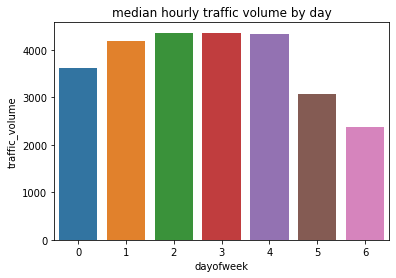

In [161]:
# traffic by day of week
sns.barplot(y="traffic_volume", x="dayofweek", data=df.groupby('dayofweek')['traffic_volume'].median().to_frame().reset_index())
plt.title('median hourly traffic volume by day')

Text(0.5, 1.0, 'median hourly traffic volume by month of year')

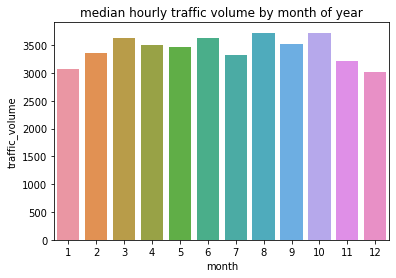

In [163]:
# traffic by month
sns.barplot(y="traffic_volume", x="month", data=df.groupby('month')['traffic_volume'].median().to_frame().reset_index())
plt.title('median hourly traffic volume by month of year')

Text(0.5, 1.0, 'median hourly traffic volume by hour of day')

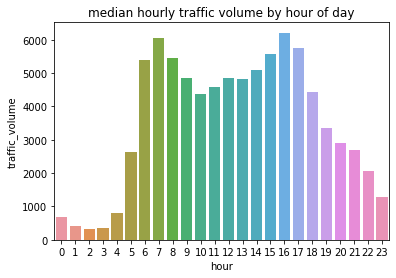

In [162]:
# traffic by time of day
sns.barplot(y="traffic_volume", x="hour", data=df.groupby('hour')['traffic_volume'].median().to_frame().reset_index())
plt.title('median hourly traffic volume by hour of day')

date_time  traffic_volume
holiday                                             
Christmas Day                      5      846.600000
Columbus Day                       5      519.400000
Independence Day                   5     1076.000000
Labor Day                          5     1013.200000
Martin Luther King Jr Day          3      592.666667
Memorial Day                       5     1107.600000
New Years Day                      5     1324.600000
None                           40522     3293.824416
State Fair                         5      634.800000
Thanksgiving Day                   5      953.600000
Veterans Day                       5      691.400000
Washingtons Birthday               5      635.200000

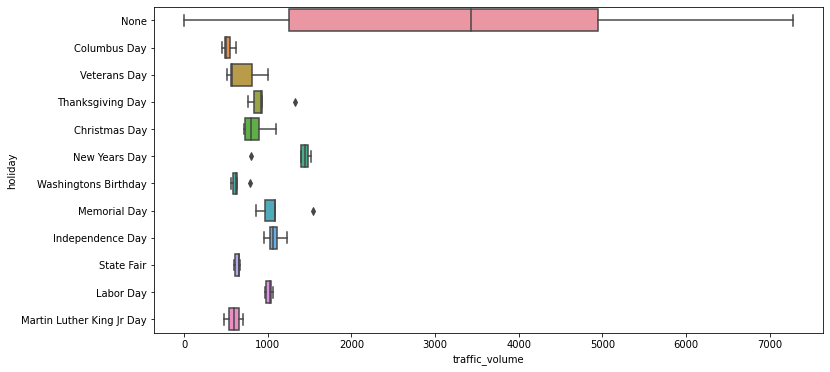

In [14]:
# how many observations and average traffic by holiday 

plt.figure(figsize=(12, 6))
ax = sns.boxplot(y='holiday', x='traffic_volume', data=df, showfliers = True)

df.groupby('holiday').agg({'date_time':'count', 'traffic_volume':'mean'})

date_time  traffic_volume
weather_main                           
Clear             13366     3055.254751
Clouds            15123     3616.988230
Drizzle             515     3159.821359
Fog                 201     2724.442786
Haze                766     3597.939948
Mist               3069     2854.214076
Rain               4769     3355.270287
Smoke                15     2559.666667
Snow               2297     3001.861123
Squall                1      420.000000
Thunderstorm        453     2993.366446

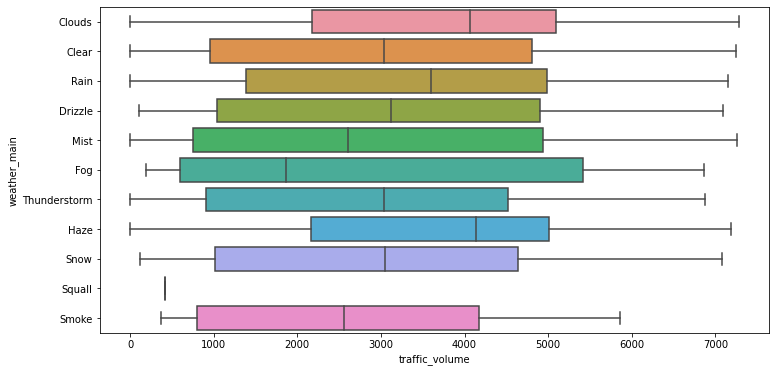

In [15]:
# how many observations per weather type 
# sns.histplot(data=df, y="weather_main")
# plt.title('observations per weather_main')
# plt.xticks(rotation=45)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(y='weather_main', x='traffic_volume', data=df, showfliers = True)

df.groupby('weather_main').agg({'date_time':'count', 'traffic_volume':'mean'})

In [16]:
print('observations with measurable rain:  ', df.loc[df['rain_1h']>0].shape[0])
print('percent of obs with measurable rain:', df.loc[df['rain_1h']>0].shape[0]/df.shape[0]*100)

observations with measurable rain:   2054
percent of obs with measurable rain: 5.062230437461491


In [17]:
print('observations with measurable snow:  ', df.loc[df['snow_1h']>0].shape[0])
print('percent of obs with measurable snow:', df.loc[df['snow_1h']>0].shape[0]/df.shape[0]*100)

observations with measurable snow:   31
percent of obs with measurable snow: 0.07640172520024646


Number of observations with measurable rain and snow does not match the number of observations by categorical labels 

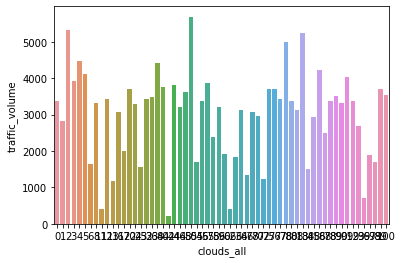

In [18]:
# does cloud cover have an impact on traffic volume? 
sns.barplot(y="traffic_volume", x="clouds_all", data=df.groupby('clouds_all')['traffic_volume'].mean().to_frame().reset_index())

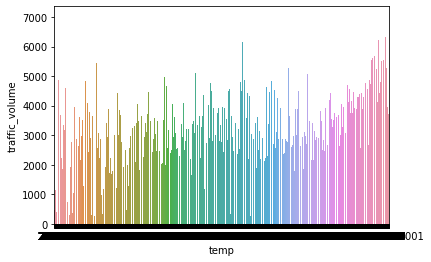

In [19]:
# does temp have an impact on traffic volume? 
sns.barplot(y="traffic_volume", x="temp", data=df.groupby('temp')['traffic_volume'].mean().to_frame().reset_index())

Looks like more traffic volume when the temp is warmer (during summer months)

In [20]:
df.groupby('weather_description').agg({'date_time':'count', 'traffic_volume':'mean'}).sort_values('date_time', ascending=False)

date_time  traffic_volume
weather_description                                           
sky is clear                             11642     3000.910067
overcast clouds                           5072     3375.779771
broken clouds                             4650     3658.193978
scattered clouds                          3451     3876.298464
mist                                      3069     2854.214076
light rain                                2831     3389.292476
few clouds                                1950     3687.205128
Sky is Clear                              1724     3422.238979
light snow                                1588     3060.358942
moderate rain                             1379     3213.158086
haze                                       766     3597.939948
heavy snow                                 500     2965.256000
heavy intensity rain                       408     3237.571078
light intensity drizzle                    360     3185.386111
proximity thunderstorm                     339     3084.401180
fog                                        201     2724.442786
snow                                       192     2510.739583
drizzle                                    138     3057.826087
proximity shower rain                      120     4616.708333
thunderstorm                                59     3103.186441
thunderstorm with light rain                23     1758.739130
very heavy rain                             18     2568.833333
heavy intensity drizzle                     17     3446.411765
smoke                                       15     2559.666667
thunderstorm with heavy rain                14     2906.428571
light intensity shower rain                 12     4109.750000
light shower snow                           11     4618.636364
proximity thunderstorm with rain             9     2354.111111
thunderstorm with rain                       5     2831.200000
light rain and snow                          3     2330.666667
sleet                                        3     4312.666667
thunderstorm with light drizzle              3     1381.333333
proximity thunderstorm with drizzle          1     6667.000000
freezing rain                                1     4762.000000
SQUALLS                                      1      420.000000

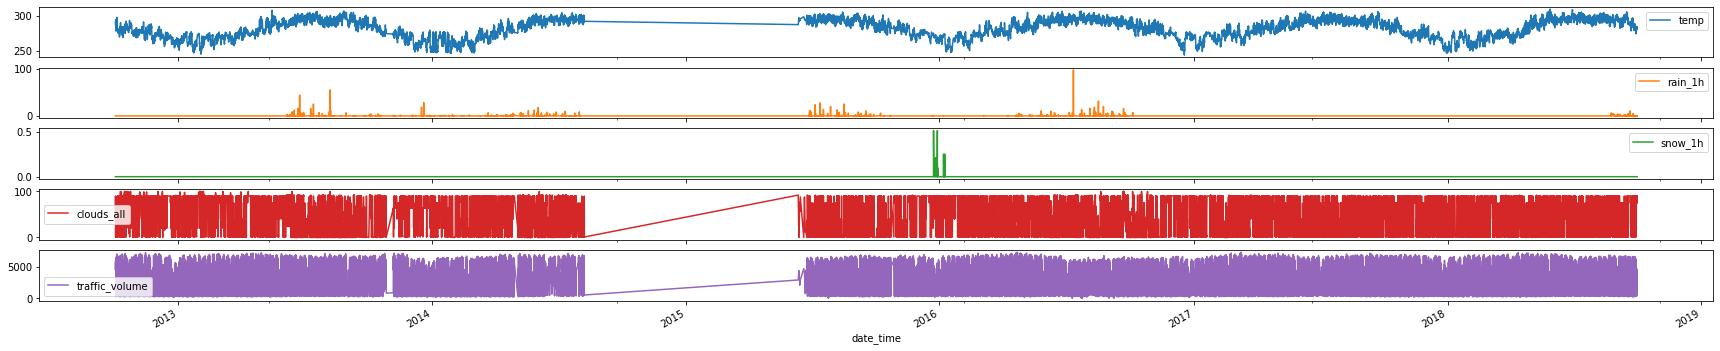

In [21]:
##From the TensorFlow Tutorial

# visualize numeric values over time 

plot_cols = ['temp','rain_1h','snow_1h','clouds_all','traffic_volume']
plot_features = df[plot_cols]
plot_features.index = df['date_time']
_ = plot_features.plot(subplots=True, figsize=(30,6))

Missing data from Augst 2014 - July 2015

# Comments on Exploratory Data Analysis
- missing data from August 2014 - July 2015
- a few extreme high or low values for temp and rain, fixed 
- significantly more observations labeled with "rain" or "snow" than listing rainfall or snowfall above 0. 
- the most noticeable patterns for traffic volume seem to be based on, roughly in order: 
1. Time of Day
2. Day of Week
3. Holiday or None 
4. Month of Year 
5. Temp
6. Weather category 

Traffic volume is more impacted by commute patterns (to work/school on weekdays with no holidays), with weather having a small effect. 

# Data Cleaning and further Exploration 

In [22]:
# create binary column for Holidays 
df['d_holiday'] = np.where(df['holiday']!='None', 1, 0)
df.head()

holiday    temp  rain_1h  snow_1h  ...  hour dayofweek month d_holiday
0    None  288.28      0.0      0.0  ...     9         1    10         0
1    None  289.36      0.0      0.0  ...    10         1    10         0
2    None  289.58      0.0      0.0  ...    11         1    10         0
3    None  290.13      0.0      0.0  ...    12         1    10         0
4    None  291.14      0.0      0.0  ...    13         1    10         0

[5 rows x 13 columns]

In [23]:
# create binary for workday (weekday and not holiday)
df['workday'] = np.where((df['holiday']=='None') & (df['dayofweek']<5) , 1, 0)
df.tail()

holiday    temp  rain_1h  snow_1h  ...  dayofweek month d_holiday workday
40570    None  283.45      0.0      0.0  ...          6     9         0       0
40571    None  282.76      0.0      0.0  ...          6     9         0       0
40572    None  282.73      0.0      0.0  ...          6     9         0       0
40573    None  282.09      0.0      0.0  ...          6     9         0       0
40574    None  282.12      0.0      0.0  ...          6     9         0       0

[5 rows x 14 columns]

In [34]:
# create binary column for rush hour
df['morning_rush'] = np.where((df['workday']==1) & (df['hour']>5) & (df['hour']<10) , 1, 0)
df['evening_rush'] = np.where((df['workday']==1) & (df['hour']>13) & (df['hour']<18) , 1, 0)
df.head()

holiday    temp  rain_1h  ...  workday  morning_rush evening_rush
0    None  288.28      0.0  ...        1             1            0
1    None  289.36      0.0  ...        1             0            0
2    None  289.58      0.0  ...        1             0            0
3    None  290.13      0.0  ...        1             0            0
4    None  291.14      0.0  ...        1             0            0

[5 rows x 16 columns]

In [35]:
# clean up the weather_description 
df.loc[(df['weather_description']=='freezing rain'),'weather_description']='snow'
df.loc[(df['weather_description']=='sleet'),'weather_description']='snow'
df.loc[(df['weather_description']=='proximity thunderstorm with drizzle'),'weather_description']='light rain'
df.loc[(df['weather_description']=='drizzle'),'weather_description']='light rain'
df.loc[(df['weather_description']=='thunderstorm with light drizzle'),'weather_description']='light rain'
df.loc[(df['weather_description']=='light rain and snow'),'weather_description']='light snow'
df.loc[(df['weather_description']=='thunderstorm with rain'),'weather_description']='rain'
df.loc[(df['weather_description']=='proximity thunderstorm with rain'),'weather_description']='rain'
df.loc[(df['weather_description']=='light shower snow'),'weather_description']='light snow'
df.loc[(df['weather_description']=='light intensity shower rain'),'weather_description']='light rain'
df.loc[(df['weather_description']=='thunderstorm with heavy rain'),'weather_description']='heavy rain'
df.loc[(df['weather_description']=='smoke'),'weather_description']='fog'
df.loc[(df['weather_description']=='heavy intensity drizzle'),'weather_description']='rain'
df.loc[(df['weather_description']=='thunderstorm with light rain'),'weather_description']='light rain'
df.loc[(df['weather_description']=='thunderstorm'),'weather_description']='rain'
df.loc[(df['weather_description']=='proximity shower rain'),'weather_description']='light rain'
df.loc[(df['weather_description']=='SQUALLS'),'weather_description']='heavy rain'
df.loc[(df['weather_description']=='proximity thunderstorm'),'weather_description']='light rain'
df.loc[(df['weather_description']=='light intensity drizzle'),'weather_description']='light rain'
df.loc[(df['weather_description']=='heavy intensity rain'),'weather_description']='heavy rain'
df.loc[(df['weather_description']=='very heavy rain'),'weather_description']='heavy rain'
df.loc[(df['weather_description']=='Sky is Clear'),'weather_description']='none'
df.loc[(df['weather_description']=='sky is clear'),'weather_description']='none'
df.loc[(df['weather_description']=='few clouds'),'weather_description']='none'
df.loc[(df['weather_description']=='scattered clouds'),'weather_description']='none'
df.loc[(df['weather_description']=='broken clouds'),'weather_description']='none'
df.loc[(df['weather_description']=='overcast clouds'),'weather_description']='none'
df.loc[(df['weather_description']=='mist'),'weather_description']='light rain'
df.loc[(df['weather_description']=='moderate rain'),'weather_description']='rain'

df.groupby('weather_description').size()

weather_description
fog             216
haze            766
heavy rain      441
heavy snow      500
light rain     6896
light snow     1602
none          28489
rain           1469
snow            196
dtype: int64

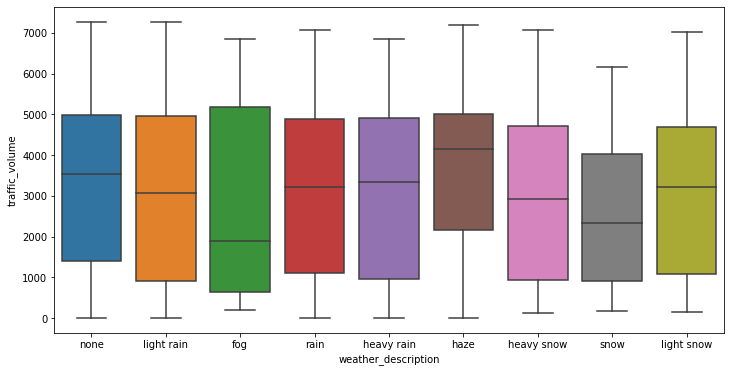

In [36]:
# traffic by weather 
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='weather_description', y='traffic_volume', data=df, showfliers = True)

In [37]:
#replace weather with binary values 
d_weather = pd.get_dummies(df['weather_description'])
df = pd.merge(left=df, right=d_weather, left_index=True, right_index=True)
df.drop(columns=['none'], inplace=True)
df.loc[df['weather_description']!='none'].head()

holiday    temp  rain_1h  snow_1h  ...  light rain light snow rain snow
164    None  287.23      0.0      0.0  ...           1          0    0    0
178    None  281.25      0.0      0.0  ...           1          0    0    0
179    None  280.10      0.0      0.0  ...           1          0    0    0
180    None  279.61      0.0      0.0  ...           1          0    0    0
216    None  283.18      0.0      0.0  ...           1          0    0    0

[5 rows x 24 columns]

# Data Transformations

In [38]:
##From the TensorFlow Tutorial

day = 24*60*60
year = (365.2425)*day
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df.head()

holiday    temp  rain_1h  snow_1h  ...       Day_sin   Day_cos  Year_sin  Year_cos
0    None  288.28      0.0      0.0  ...  7.071068e-01 -0.707107 -0.999766  0.021642
1    None  289.36      0.0      0.0  ...  5.000000e-01 -0.866025 -0.999750  0.022358
2    None  289.58      0.0      0.0  ...  2.588190e-01 -0.965926 -0.999734  0.023075
3    None  290.13      0.0      0.0  ...  1.143105e-11 -1.000000 -0.999717  0.023791
4    None  291.14      0.0      0.0  ... -2.588190e-01 -0.965926 -0.999700  0.024508

[5 rows x 28 columns]

Text(0.5, 1.0, 'Time of day signal')

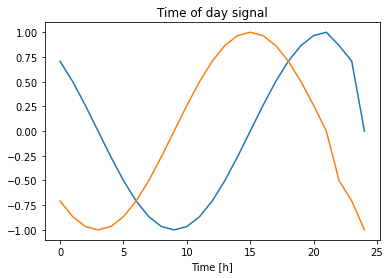

In [39]:
##From the TensorFlow Tutorial

plt.plot(np.array(df['Day_sin'])[:25])
plt.plot(np.array(df['Day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [41]:
# create numeric data set with encoded categorical columns
df_num2 = df[['traffic_volume', 'temp', 'hour', 'dayofweek', 'month', 'd_holiday', 'workday', 'morning_rush', 'evening_rush', 'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos',
              'fog', 'haze', 'heavy rain', 'heavy snow', 'light rain', 'light snow', 'rain', 'snow']].copy()
df_num2.tail()

traffic_volume    temp  hour  ...  light snow  rain  snow
40570            3543  283.45    19  ...           0     0     0
40571            2781  282.76    20  ...           0     0     0
40572            2159  282.73    21  ...           0     0     0
40573            1450  282.09    22  ...           0     0     0
40574             954  282.12    23  ...           0     0     0

[5 rows x 21 columns]

# Train / Test Split 
- use dataset with numeric values + encoded categorical values

In [42]:
# separate last 5000 rows for test set 
test_df = df_num2[-5000:]
train_val_df = df_num2[:-5000]

print(train_val_df.shape)
train_val_df.tail()

(35575, 21)


traffic_volume    temp  hour  ...  light snow  rain  snow
35570            1389  271.93    18  ...           0     0     0
35571            1117  271.65    19  ...           0     0     0
35572             844  271.28    20  ...           0     0     1
35573             753  271.15    21  ...           0     0     1
35574             694  271.15    22  ...           0     0     1

[5 rows x 21 columns]

In [43]:
print(test_df.shape)
test_df.head()

(5000, 21)


traffic_volume    temp  hour  ...  light snow  rain  snow
35575             599  271.36    23  ...           1     0     0
35576             308  271.43     0  ...           1     0     0
35577             242  271.43     1  ...           1     0     0
35578             231  271.36     2  ...           1     0     0
35579             335  271.28     3  ...           1     0     0

[5 rows x 21 columns]

In [44]:
# split remaining rows into train/validation set 

n = len(train_val_df)
train_df = train_val_df[0:int(n*0.7)]
val_df = train_val_df[int(n*0.7):-1]

print(train_df.shape)
train_df.tail()

(24902, 21)


traffic_volume     temp  hour  ...  light snow  rain  snow
24897            4165  254.917    18  ...           0     0     0
24898            3145  254.917    19  ...           0     0     0
24899            2617  257.960    20  ...           0     0     0
24900            3055  258.880    21  ...           0     0     0
24901            3738  260.020    22  ...           0     0     0

[5 rows x 21 columns]

In [45]:
print(val_df.shape)
val_df.head()

(10672, 21)


traffic_volume    temp  hour  ...  light snow  rain  snow
24902            1205  260.42    23  ...           0     0     0
24903             587  260.75     0  ...           0     0     0
24904             381  260.59     1  ...           0     0     0
24905             369  260.42     2  ...           0     0     0
24906             486  260.34     3  ...           0     0     0

[5 rows x 21 columns]

Normalize the data

In [46]:
##From the TensorFlow Tutorial

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df.head()

traffic_volume      temp      hour  ...  light snow      rain      snow
0        1.149755  0.541804 -0.360910  ...   -0.172425 -0.187642 -0.054593
1        0.632510  0.624278 -0.217380  ...   -0.172425 -0.187642 -0.054593
2        0.758680  0.641078 -0.073851  ...   -0.172425 -0.187642 -0.054593
3        0.888871  0.683078  0.069678  ...   -0.172425 -0.187642 -0.054593
4        0.834582  0.760206  0.213207  ...   -0.172425 -0.187642 -0.054593

[5 rows x 21 columns]

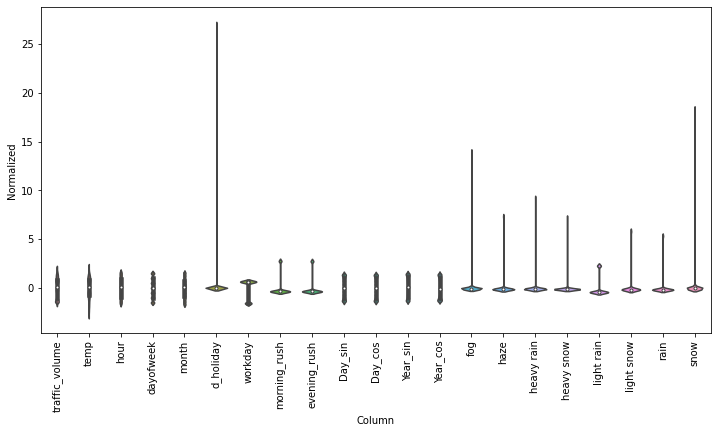

In [47]:
##From the TensorFlow Tutorial

# check distributions 
df_std = (df_num2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_num2.keys(), rotation=90)

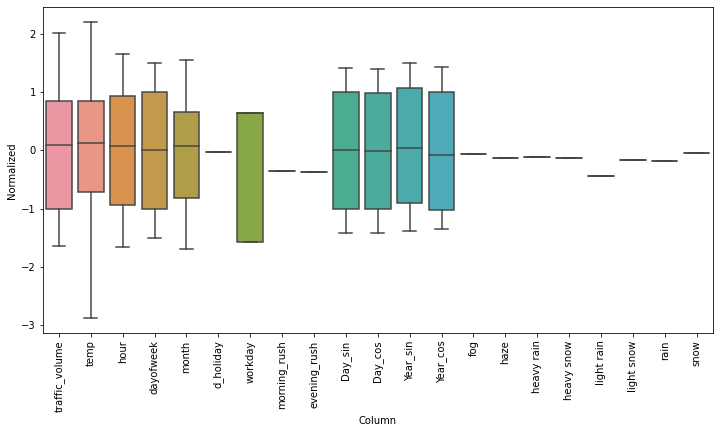

In [48]:
#plot without outliers 

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Column', y='Normalized', data=df_std, showfliers = False)
_ = ax.set_xticklabels(df_num2.keys(), rotation=90)

# Window Generator and other Functions/Classes

In [49]:
##From the TensorFlow Tutorial

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [50]:
##From the TensorFlow Tutorial

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [51]:
##From the TensorFlow Tutorial

def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [52]:
##From the TensorFlow Tutorial

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [53]:
##From the TensorFlow Tutorial

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [104]:
##From the TensorFlow Tutorial

MAX_EPOCHS = 20
column_indices = {name: i for i, name in enumerate(df_num2.columns)}
num_features = df_num2.shape[1]

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Single-Output Model 
Baseline model - 1 LSTM layer with default settings 

Total window size: 10
Input indices: [0 1 2 3 4 5 6]
Label indices: [9]
Label column name(s): ['traffic_volume']

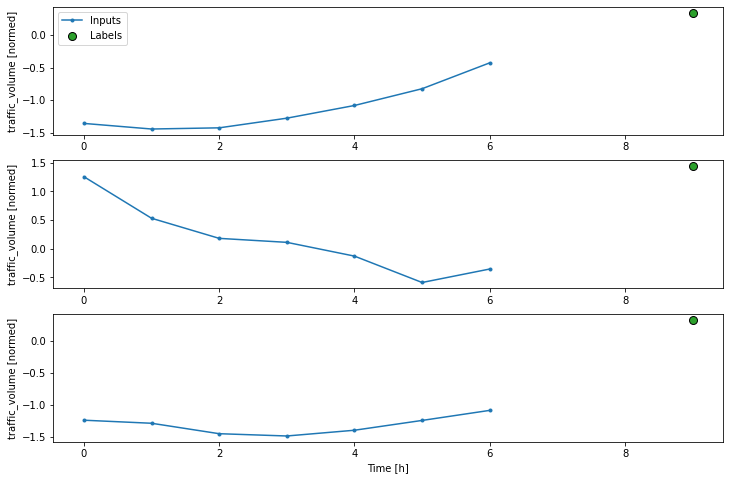

In [105]:
window_7_1_3 = WindowGenerator(
    input_width=7, label_width=1, shift=3,
    label_columns=['traffic_volume'])

window_7_1_3.plot()
window_7_1_3

In [106]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([1, 1])
])

In [107]:
print('Input shape:', window_7_1_3.example[0].shape)
print('Output shape:', lstm_model(window_7_1_3.example[0]).shape)

Input shape: (32, 7, 21)
Output shape: (32, 1, 1)


In [108]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=10, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

In [109]:
print('Train_MAE:', history.history['mean_absolute_error'][-1])
print('Val_MAE:  ', history.history['val_mean_absolute_error'][-1])
print('Test_MAE: ', lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1])

Train_MAE: 0.19322408735752106
Val_MAE:   0.16483460366725922
Test_MAE:  0.1295919567346573


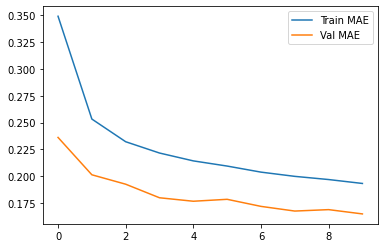

In [110]:
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

# Model Tuning 
model architecture - layers, dropout, etc

## Tuning steps

In [125]:
df_test_results = pd.DataFrame(columns = ['LSTM_layers', 'Conv_layers', 'Dense_layers', 'Units', 'Epochs', 'Batch_size', 'Dropout','Bidirect',
                                          'Train_MAE', 'Val_MAE','Test_MAE','History'])

# add baseline model results 
df_test_results = df_test_results.append({"LSTM_layers":1, "Conv_layers":0, "Dense_layers":1, "Units":32, "Epochs":20,'Batch_size':32, 'Dropout':0.0, 'Bidirect':False,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)
df_test_results

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...

[1 rows x 12 columns]

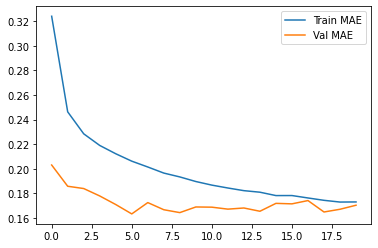

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...

[2 rows x 12 columns]

In [127]:
# Try Bidirectional LSTM 

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 1    #lstm layers
c = 0    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False, dropout=d)),
    tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Test MAE is higher but less overfitting 

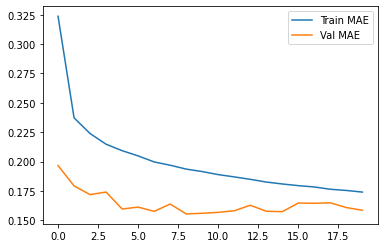

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...

[3 rows x 12 columns]

In [129]:
# Try Convolutional layer

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 1    #lstm layers
c = 1    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), activation='relu'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False, dropout=d)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Lowest Val MAE and Test MAE 

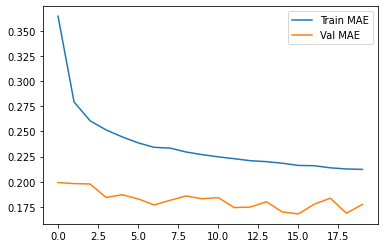

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...

[4 rows x 12 columns]

In [131]:
# Add dropout to Conv layer

u = 32   #units
b = 32   #batch size 
d = 0.3  #dropout 
e = 20   #epochs 
l = 1    #lstm layers
c = 1    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), activation='relu'),
  tf.keras.layers.Dropout(d),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Dropout on Conv layer did not help 

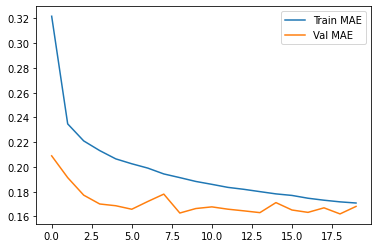

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4           2  ...  <keras.callbacks.History object at 0x7fbd74438...

[5 rows x 12 columns]

In [132]:
# Revert Dropout back to 0, add another LSTM layer 

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 2    #lstm layers
c = 1    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), activation='relu'),
  tf.keras.layers.Dropout(d),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Not better but not the worst 

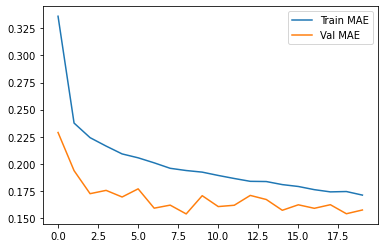

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4           2  ...  <keras.callbacks.History object at 0x7fbd74438...
5           3  ...  <keras.callbacks.History object at 0x7fbd686b8...

[6 rows x 12 columns]

In [133]:
# Add another LSTM layer 

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 3    #lstm layers
c = 1    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), activation='relu'),
  tf.keras.layers.Dropout(d),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Not much change 

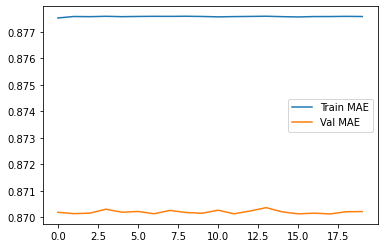

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4           2  ...  <keras.callbacks.History object at 0x7fbd74438...
5           3  ...  <keras.callbacks.History object at 0x7fbd686b8...
6           3  ...  <keras.callbacks.History object at 0x7fbd5807e...

[7 rows x 12 columns]

In [135]:
# Add another Dense layer 

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 3    #lstm layers
c = 1    #conv layers 
dl= 2    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), activation='relu'),
  tf.keras.layers.Dropout(d),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Significantly worse performance 

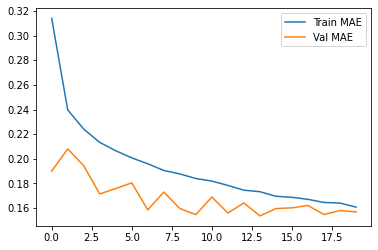

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4           2  ...  <keras.callbacks.History object at 0x7fbd74438...
5           3  ...  <keras.callbacks.History object at 0x7fbd686b8...
6           3  ...  <keras.callbacks.History object at 0x7fbd5807e...
7           2  ...  <keras.callbacks.History object at 0x7fbcc7c4a...

[8 rows x 12 columns]

In [136]:
# 2 LSTM no conv

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 2    #lstm layers
c = 0    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Improvement over 1 LSTM but not over 1 LSTM 1 Conv

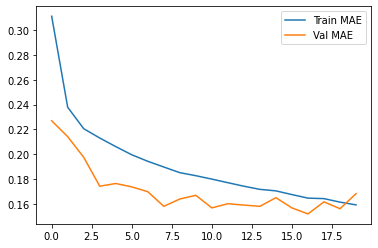

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4           2  ...  <keras.callbacks.History object at 0x7fbd74438...
5           3  ...  <keras.callbacks.History object at 0x7fbd686b8...
6           3  ...  <keras.callbacks.History object at 0x7fbd5807e...
7           2  ...  <keras.callbacks.History object at 0x7fbcc7c4a...
8           3  ...  <keras.callbacks.History object at 0x7fbd741a1...

[9 rows x 12 columns]

In [137]:
# 3 LSTM no conv

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 3    #lstm layers
c = 0    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

No improvement

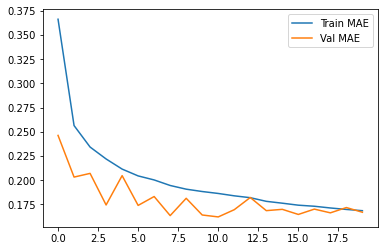

LSTM_layers  ...                                            History
0           1  ...  <keras.callbacks.History object at 0x7fbe04906...
1           1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2           1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3           1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4           2  ...  <keras.callbacks.History object at 0x7fbd74438...
5           3  ...  <keras.callbacks.History object at 0x7fbd686b8...
6           3  ...  <keras.callbacks.History object at 0x7fbd5807e...
7           2  ...  <keras.callbacks.History object at 0x7fbcc7c4a...
8           3  ...  <keras.callbacks.History object at 0x7fbd741a1...
9           3  ...  <keras.callbacks.History object at 0x7fbcb4cb1...

[10 rows x 12 columns]

In [138]:
# 3 LSTM without bidirectional

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 3    #lstm layers
c = 0    #conv layers 
dl= 1    #dense layers 
bi= False #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(u, return_sequences=True),
  tf.keras.layers.LSTM(u, return_sequences=True),
  tf.keras.layers.LSTM(u, return_sequences=False),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

No improvement

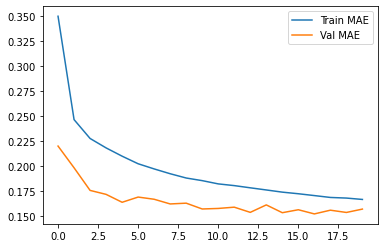

LSTM_layers  ...                                            History
0            1  ...  <keras.callbacks.History object at 0x7fbe04906...
1            1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2            1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3            1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4            2  ...  <keras.callbacks.History object at 0x7fbd74438...
5            3  ...  <keras.callbacks.History object at 0x7fbd686b8...
6            3  ...  <keras.callbacks.History object at 0x7fbd5807e...
7            2  ...  <keras.callbacks.History object at 0x7fbcc7c4a...
8            3  ...  <keras.callbacks.History object at 0x7fbd741a1...
9            3  ...  <keras.callbacks.History object at 0x7fbcb4cb1...
10           2  ...  <keras.callbacks.History object at 0x7fbcb2324...

[11 rows x 12 columns]

In [139]:
# 2 LSTM without bidirectional

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 2    #lstm layers
c = 0    #conv layers 
dl= 1    #dense layers 
bi= False #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(u, return_sequences=True),
  tf.keras.layers.LSTM(u, return_sequences=False),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

Best performance 

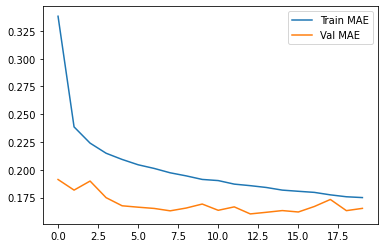

LSTM_layers  ...                                            History
0            1  ...  <keras.callbacks.History object at 0x7fbe04906...
1            1  ...  <keras.callbacks.History object at 0x7fbbe074f...
2            1  ...  <keras.callbacks.History object at 0x7fbc0ba64...
3            1  ...  <keras.callbacks.History object at 0x7fbd7521c...
4            2  ...  <keras.callbacks.History object at 0x7fbd74438...
5            3  ...  <keras.callbacks.History object at 0x7fbd686b8...
6            3  ...  <keras.callbacks.History object at 0x7fbd5807e...
7            2  ...  <keras.callbacks.History object at 0x7fbcc7c4a...
8            3  ...  <keras.callbacks.History object at 0x7fbd741a1...
9            3  ...  <keras.callbacks.History object at 0x7fbcb4cb1...
10           2  ...  <keras.callbacks.History object at 0x7fbcb2324...
11           2  ...  <keras.callbacks.History object at 0x7fbcaf70c...

[12 rows x 12 columns]

In [140]:
# 2 LSTM without bidirectional and 1 conv

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 2    #lstm layers
c = 1    #conv layers 
dl= 1    #dense layers 
bi= False #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=(7,), activation='relu'),
  tf.keras.layers.LSTM(u, return_sequences=True),
  tf.keras.layers.LSTM(u, return_sequences=False),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

df_test_results = df_test_results.append({"LSTM_layers":l, "Conv_layers":c, "Dense_layers":dl, "Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d, 'Bidirect':bi,
                                          'Train_MAE':history.history['mean_absolute_error'][-1], 
                                          'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                          'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                          'History':history}, ignore_index=True)

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

df_test_results

## Best model structure based on lower MAE on Val/Test and also lower overfitting 
- 2 LSTM with Bidirectional, 0 Conv, 1 Dense

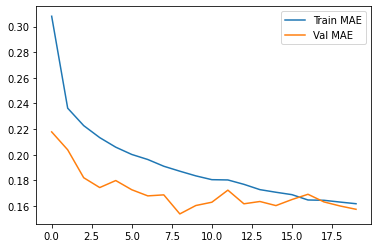

Train_MAE:  0.16179998219013214
Val_MAE:    0.1574583351612091
Test_MAE:   0.1278855949640274


In [141]:
# 2 LSTM no conv

u = 32   #units
b = 32   #batch size 
d = 0.0  #dropout 
e = 20   #epochs 
l = 2    #lstm layers
c = 0    #conv layers 
dl= 1    #dense layers 
bi= True #bidirectional

lstm_model = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False)),
  tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([1, 1])
])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

IPython.display.clear_output()

plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

print('Train_MAE: ',history.history['mean_absolute_error'][-1])
print('Val_MAE:   ',history.history['val_mean_absolute_error'][-1])
print('Test_MAE:  ',lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1])

# Hyperparameter Tuning Loop

In [151]:
# Try different values 

df_test_results = pd.DataFrame(columns = ['Units', 'Epochs', 'Batch_size', 'Dropout',
                                          'Train_MAE', 'Val_MAE','Test_MAE','History'])

units_vals = [32, 64, 128]
batch_vals = [32, 64, 128]
ep_vals = [10, 20]
do_vals = [0.0, 0.2, 0.4]

for u in units_vals: 
  for b in batch_vals:
    for e in ep_vals: 
      for d in do_vals:
        print('units:',u,', batch:',b,', epochs:',e,', dropout:',d)

        lstm_model = tf.keras.Sequential([
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True, dropout=d)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False, dropout=d)),
          tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
          tf.keras.layers.Reshape([1, 1])
        ])

        lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
        history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val)  

        IPython.display.clear_output()

        df_test_results = df_test_results.append({"Units":u, "Epochs":e,'Batch_size':b, 'Dropout':d,
                                                      'Train_MAE':history.history['mean_absolute_error'][-1], 
                                                      'Val_MAE':history.history['val_mean_absolute_error'][-1],
                                                      'Test_MAE':lstm_model.evaluate(window_7_1_3.test, verbose=0)[-1],
                                                      'History':history}, ignore_index=True)


In [152]:
df_test_results

Units Epochs  ...  Test_MAE                                            History
0     32     10  ...  0.122319  <keras.callbacks.History object at 0x7fbca4b08...
1     32     10  ...  0.128652  <keras.callbacks.History object at 0x7fbca4b74...
2     32     10  ...  0.140860  <keras.callbacks.History object at 0x7fbc9e7fc...
3     32     20  ...  0.143686  <keras.callbacks.History object at 0x7fbbfd7e5...
4     32     20  ...  0.119792  <keras.callbacks.History object at 0x7fbbfb07c...
5     32     20  ...  0.134941  <keras.callbacks.History object at 0x7fbca5658...
6     32     10  ...  0.133466  <keras.callbacks.History object at 0x7fbcaa64c...
7     32     10  ...  0.128978  <keras.callbacks.History object at 0x7fbbf81ec...
8     32     10  ...  0.143098  <keras.callbacks.History object at 0x7fbbf699e...
9     32     20  ...  0.128472  <keras.callbacks.History object at 0x7fbbf51b1...
10    32     20  ...  0.124157  <keras.callbacks.History object at 0x7fbbf3a78...
11    32     20  ...  0.135349  <keras.callbacks.History object at 0x7fbcaa5e3...
12    32     10  ...  0.137337  <keras.callbacks.History object at 0x7fbcaa5e9...
13    32     10  ...  0.142077  <keras.callbacks.History object at 0x7fbbf0991...
14    32     10  ...  0.153563  <keras.callbacks.History object at 0x7fbbef129...
15    32     20  ...  0.125773  <keras.callbacks.History object at 0x7fbbef11b...
16    32     20  ...  0.128568  <keras.callbacks.History object at 0x7fbbec1fd...
17    32     20  ...  0.138816  <keras.callbacks.History object at 0x7fbbb0b30...
18    64     10  ...  0.127494  <keras.callbacks.History object at 0x7fbbef70e...
19    64     10  ...  0.126957  <keras.callbacks.History object at 0x7fbbef744...
20    64     10  ...  0.131858  <keras.callbacks.History object at 0x7fbbef744...
21    64     20  ...  0.137665  <keras.callbacks.History object at 0x7fbba8316...
22    64     20  ...  0.118610  <keras.callbacks.History object at 0x7fbba3b12...
23    64     20  ...  0.151269  <keras.callbacks.History object at 0x7fbb9fc23...
24    64     10  ...  0.125698  <keras.callbacks.History object at 0x7fbb9cb16...
25    64     10  ...  0.130066  <keras.callbacks.History object at 0x7fbb99b0e...
26    64     10  ...  0.133359  <keras.callbacks.History object at 0x7fbb96aab...
27    64     20  ...  0.140709  <keras.callbacks.History object at 0x7fbba5806...
28    64     20  ...  0.141230  <keras.callbacks.History object at 0x7fbbac7f8...
29    64     20  ...  0.138628  <keras.callbacks.History object at 0x7fbb7a2cb...
30    64     10  ...  0.137520  <keras.callbacks.History object at 0x7fbb76a75...
31    64     10  ...  0.135228  <keras.callbacks.History object at 0x7fbb75af5...
32    64     10  ...  0.138410  <keras.callbacks.History object at 0x7fbb71a8f...
33    64     20  ...  0.140103  <keras.callbacks.History object at 0x7fbb6fe25...
34    64     20  ...  0.124370  <keras.callbacks.History object at 0x7fbb6cb65...
35    64     20  ...  0.134099  <keras.callbacks.History object at 0x7fbb6b382...
36   128     10  ...  0.130008  <keras.callbacks.History object at 0x7fbb68b0f...
37   128     10  ...  0.121846  <keras.callbacks.History object at 0x7fbb663d2...
38   128     10  ...  0.133048  <keras.callbacks.History object at 0x7fbb663bb...
39   128     20  ...  0.135605  <keras.callbacks.History object at 0x7fbb6aa62...
40   128     20  ...  0.126177  <keras.callbacks.History object at 0x7fbb61d04...
41   128     20  ...  0.120842  <keras.callbacks.History object at 0x7fbb5ed20...
42   128     10  ...  0.126952  <keras.callbacks.History object at 0x7fbb5c4d9...
43   128     10  ...  0.125286  <keras.callbacks.History object at 0x7fbb58d20...
44   128     10  ...  0.138409  <keras.callbacks.History object at 0x7fbb55d41...
45   128     20  ...  0.127097  <keras.callbacks.History object at 0x7fbb534e3...
46   128     20  ...  0.121978  <keras.callbacks.History object at 0x7fbb4fd93...
47   128     20  ...  0.142108  <keras.callbacks.History object at 

## Best Model from Hyper parameter tuning 

In [153]:
u = 64  
e =	20
b = 32
d = 0.2

lstm_model = tf.keras.Sequential([
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=True, dropout=d)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(u, return_sequences=False, dropout=d)),
          tf.keras.layers.Dense(1*1, kernel_initializer=tf.initializers.zeros()),
          tf.keras.layers.Reshape([1, 1])
        ])

lstm_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = lstm_model.fit(window_7_1_3.train, epochs=e, batch_size=b, validation_data=window_7_1_3.val, verbose=1)  

IPython.display.clear_output()


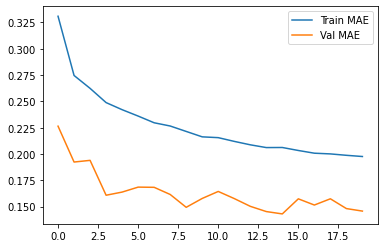

In [154]:
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.legend()
plt.show()

# Predictions

In [155]:
# make predictions
#yhat = multi_lstm_model.predict(window_7_1_3.test)
yhat = lstm_model.predict(window_7_1_3.test)
yhat.shape

(4991, 1, 1)

In [156]:
# reshape 
preds = yhat.reshape(yhat.shape[0], yhat.shape[2])

# convert to dataframe 
predictions = pd.DataFrame(preds, columns = ['prediction'])
predictions.head()

prediction
0    0.896439
1    0.051826
2    0.737286
3   -1.037128
4   -0.851298

In [157]:
# de-normalize 

inv_preds = (predictions*train_std['traffic_volume']) + train_mean['traffic_volume']
inv_preds.head()

prediction
0  5041.057129
1  3360.797119
2  4724.439941
3  1194.448730
4  1564.135010

In [158]:
# create dataframe for submission 

#pred_tv = inv_preds[['traffic_volume']].copy()
inv_preds['id'] = inv_preds.index+1
id = inv_preds['id']
inv_preds.drop(labels=['id'], axis=1,inplace = True)
inv_preds.insert(0, 'id', id)
#inv_preds.rename(columns={"traffic_volume": "prediction"}, inplace=True)

inv_preds.head()

id   prediction
0   1  5041.057129
1   2  3360.797119
2   3  4724.439941
3   4  1194.448730
4   5  1564.135010

In [159]:
from google.colab import  drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [160]:
inv_preds.to_csv('/drive/My Drive/Academics/CSC 578/final/mw_preds_final_13.csv', index=False)